<a href="https://colab.research.google.com/github/ghostli123/DynAuth-Server/blob/master/CS336_Transformer_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq tiktoken grain matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.8 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp

from jax.sharding import Mesh, PartitionSpec as P, NamedSharding
from jax.experimental import mesh_utils

import flax.nnx as nnx
from flax.nnx import LinearGeneral
import optax

from dataclasses import dataclass
import grain.python as pygrain
import pandas as pd
import tiktoken
import time
from typing import Optional, Any, List

tokenizer = tiktoken.get_encoding("gpt2")

vocab_size = tokenizer.n_vocab
num_layers = 8
max_seq_len = 128
model_d = 256
num_heads = 8
feed_forward_dim = 256
batch_size = 256
num_epochs = 1

## Loading and preprocessing the data

In [ ]:
!wget https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true -O TinyStories-train.txt

--2025-08-03 20:16:05--  https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStories-train.txt?download=true
Resolving huggingface.co (huggingface.co)... 3.170.185.25, 3.170.185.14, 3.170.185.33, ...
Connecting to huggingface.co (huggingface.co)|3.170.185.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/42/7f/427f7497b6c6596c18b46d5a72e61364fcad12aa433c60a0dbd4d344477b9d81/c5cf5e22ff13614e830afbe61a99fbcbe8bcb7dd72252b989fa1117a368d401f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27TinyStories-train.txt%3B+filename%3D%22TinyStories-train.txt%22%3B&response-content-type=text%2Fplain&Expires=1754255765&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1NDI1NTc2NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Mi83Zi80MjdmNzQ5N2I2YzY1OTZjMThiNDZkNWE3MmU2MTM2NGZjYWQxMmFhNDMzYzYwYTBkYmQ0ZDM0NDQ3N2I5ZDgxL2M1Y2Y1ZTIyZmYxMzYxNGU4MzBhZmJlNjFhOTlm

In [ ]:
@dataclass
class TextDataset:
  data: list
  maxlen: int

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx: int):
    # Use Tiktoken for tokenization
    encoding = tokenizer.encode(self.data[idx], allowed_special={'<|endoftext|>'})[:self.maxlen]  # Tokenize and truncate
    return encoding + [0] * (self.maxlen - len(encoding))  # Pad to maxlen

def load_and_preprocess_data(file_path, batch_size, maxlen):
  with open(file_path, 'r') as f:
    text = f.read()

  stories = text.split('<|endoftext|>')
  stories = [story+'<|endoftext|>' for story in stories if story.strip()]
  df = pd.DataFrame({'text': stories})
  data = df['text'].dropna().tolist()
  dataset = TextDataset(data, maxlen)

  sampler = pygrain.IndexSampler(
      len(dataset),
      shuffle=False,
      seed=42,
      shard_options=pygrain.NoSharding(),
      num_epochs=num_epochs,
  )

  dl = pygrain.DataLoader(
      data_source=dataset,
      sampler=sampler,
      operations=[pygrain.Batch(batch_size=batch_size, drop_remainder=True)],
  )

  return dl

text_dl = load_and_preprocess_data('TinyStories-train.txt', batch_size, max_seq_len)

In [ ]:
device_mesh = mesh_utils.create_device_mesh((jax.device_count(),))
mesh = Mesh(device_mesh, axis_names=('batch',))
print(f"Using a {device_mesh.shape} JAX device mesh for data parallelism: ('batch',)")


Using a (8,) JAX device mesh for data parallelism: ('batch',)


# Model

## RMSNorm

In [ ]:
def replicated_init(initializer):
  """Helper function to create a replicated initializer for data parallelism."""
  # An empty PartitionSpec P() or P(None) signifies replication across all mesh axes.
  if mesh:
      return nnx.with_partitioning(initializer, NamedSharding(mesh, P()))
  return initializer

# Replicated initializers for model parameters.
# In a data-parallel model, all weights are fully replicated on every device.
replicated_xavier_init = replicated_init(nnx.initializers.xavier_uniform())
replicated_normal_init = replicated_init(nnx.initializers.normal())
replicated_zeros_init = replicated_init(nnx.initializers.zeros_init())
replicated_ones_init = replicated_init(nnx.initializers.ones_init())

class RMSNorm(nnx.Module):
  """A Root Mean Square Normalization module."""
  def __init__(self, num_features: int, epsilon: float = 1e-6, *, rngs: nnx.Rngs):
    self.epsilon = epsilon
    # The scale parameter is initialized to 1 and replicated across devices.
    key = rngs.params()
    shape = (num_features,)
    # Call the initializer with both the key and the shape
    self.scale = nnx.Param(replicated_ones_init(key, shape))

  def __call__(self, x: jax.Array) -> jax.Array:
    x_dtype = x.dtype
    x = x.astype(jnp.float32)
    # Compute the variance of the input and normalize.
    variance = jnp.mean(jnp.square(x), axis=-1, keepdims=True)
    x_norm = x * jax.lax.rsqrt(variance + self.epsilon)
    # Scale the normalized input.
    return (self.scale * x_norm).astype(x_dtype)

## Attention and RoPE

In [ ]:
class RoPE(nnx.Module):
  """
  A Flax NNX module that applies Rotary Positional Embeddings (RoPE).
  (User-provided implementation)
  """
  def __init__(
      self,
      theta: float,
      d_k: int,
      max_seq_len: int,
      *,
      rngs: nnx.Rngs | None = None,
  ):
    """Initializes the RoPE module and precomputes sinusoidal embeddings."""
    if d_k % 2 != 0:
        raise ValueError(f"d_k must be even, but got {d_k}")

    self.theta = theta
    self.d_k = d_k
    self.max_seq_len = max_seq_len

    fraction = 2 * jnp.arange(0, self.d_k // 2, dtype=jnp.float32) / self.d_k
    timescale = self.theta**fraction
    positions = jnp.arange(self.max_seq_len, dtype=jnp.float32)
    sinusoid_inp = positions[:, None] / timescale[None, :]

    # These parameters will be replicated on all devices by default in a data-parallel setup.
    self.sin = jnp.sin(sinusoid_inp)
    self.cos = jnp.cos(sinusoid_inp)

  def __call__(
      self, x: jax.Array,
      token_positions: jax.Array
  ) -> jax.Array:
    """
    Applies the precomputed RoPE to an input tensor.

    Args:
      inputs: The input sequence on which to apply the Rotary position
        embedding. Since rotary position embeddings are applied to query and
        keys after projection, it is assumed of shape [B, S, N, H].
      position: Optional position jax.Array which denotes the position of each
        token in the sequence. This only needs to be supplied when the sequence
        is packed. It is of shape [B, S].

    Returns:
      a jax.Array of shape [B, S, N, H] which includes the inputs together with
      the rotary position embedding incorporated in it.
    """
    while len(token_positions.shape) < len(x.shape) - 1:
        token_positions = token_positions[..., None]

    sin = self.sin[token_positions]
    cos = self.cos[token_positions]

    first_half, second_half = jnp.split(x, 2, axis=-1)

    first_part = first_half * cos - second_half * sin
    second_part = second_half * cos + first_half * sin

    out = jnp.concatenate([first_part, second_part], axis=-1)
    return out.astype(x.dtype)

In [ ]:
class ScaledDotProductAttention(nnx.Module):
  """User-provided implementation."""
  def __init__(self):
    super().__init__()

  def __call__(
      self,
      query: jax.Array,
      key: jax.Array,
      value: jax.Array,
      mask: Optional[jax.Array] = None,
  ) -> jax.Array:
    d_k = query.shape[-1]
    scores = jnp.einsum("...qd,...kd->...qk", query, key) / jnp.sqrt(d_k)
    if mask is not None:
      scores = jnp.where(mask, scores, -1e9)
    attention_weights = nnx.softmax(scores, axis=-1)
    output = jnp.einsum("...qk,...kv->...qv", attention_weights, value)
    return output

### Multi-Head Attention: Tensor Flow and Operations

**Variable Definitions:**
* `b`: `batch_size`
* `s`: `sequence_length`
* `d`: `d_model`
* `h`: `num_heads`
* `e`: `head_dim` (`d_model / num_heads`)

| Layer / Step | Tensor Shape | Operation Applied |
| :--- | :--- | :--- |
| **Input** | `(b, s, d)` | Initial embedding for each token in the sequence. |
| **`q_proj`, `k_proj`, `v_proj`** | `(b, s, h, e)` | **Linear Projection**: Projects input `x` into Q, K, and V tensors with split heads. |
| **`rope`** (Optional) | `(b, h, s, e)` | **Positional Encoding**: Injects sequence order information into Q and K. |
| **Transpose for Attention** | `(b, h, s, e)` | **`jnp.einsum('bshd->bhsd', ...)`**: Swaps `sequence` and `head` dimensions. |
| **`attention`** | `(b, h, s, e)` | **Scaled Dot-Product Attention**: Computes `softmax(Q @ K^T / sqrt(e)) @ V`. |
| **Transpose to Merge** | `(b, s, h, e)` | **`jnp.einsum('bhsd->bshd', ...)`**: Swaps `head` and `sequence` dimensions back. |
| **`out_proj`** | `(b, s, d)` | **Linear Projection**: Merges heads and projects back to the original `d_model`. |

In [ ]:
class MultiHeadAttention(nnx.Module):
  """
  Casual Multi-Head Attention.
  (User-provided, modified to use REPLICATED initializers for data parallelism)
  """
  def __init__(
      self,
      d_model: int,
      num_heads: int,
      use_bias: bool = False,
      param_dtype: Any = jnp.bfloat16,
      rope: Optional[RoPE] = None,
      *,
      rngs: nnx.Rngs,
  ):
    if d_model % num_heads != 0:
      raise ValueError(f"d_model ({d_model}) must be divisible by num_heads ({num_heads})")

    self.num_heads = num_heads
    self.d_model = d_model
    self.head_dim = d_model // num_heads

    # Using replicated initializers for data parallelism.
    self.q_proj = LinearGeneral(
        in_features=d_model,
        out_features=(self.num_heads, self.head_dim),
        use_bias=use_bias, dtype=param_dtype, rngs=rngs,
        kernel_init=replicated_xavier_init
    )
    self.k_proj = LinearGeneral(
        in_features=d_model,
        out_features=(self.num_heads, self.head_dim),
        use_bias=use_bias, dtype=param_dtype, rngs=rngs,
        kernel_init=replicated_xavier_init
    )
    self.v_proj = LinearGeneral(
        in_features=d_model,
        out_features=(self.num_heads, self.head_dim),
        use_bias=use_bias, dtype=param_dtype, rngs=rngs,
        kernel_init=replicated_xavier_init
    )

    self.attention = ScaledDotProductAttention()

    self.out_proj = LinearGeneral(
        in_features=(self.num_heads, self.head_dim),
        out_features=d_model,
        axis=(-2, -1), # Specify that the last two axes are the feature axes.
        use_bias=use_bias, dtype=param_dtype, rngs=rngs,
        kernel_init=replicated_xavier_init
    )
    self.rope = rope

  def __call__(self, x: jax.Array) -> jax.Array:
    seq_len = x.shape[1]
    causal_mask = jnp.tril(jnp.ones((seq_len, seq_len), dtype=bool))
    query = self.q_proj(x)
    key = self.k_proj(x)
    value = self.v_proj(x)

    if self.rope:
      positions = jnp.arange(seq_len)[None, :] # [1, s]
      query = self.rope(query, token_positions=positions)
      key = self.rope(key, token_positions=positions)

    query = jnp.einsum('bshd->bhsd', query)
    key = jnp.einsum('bshd->bhsd', key)
    value = jnp.einsum('bshd->bhsd', value)

    causal_mask = causal_mask[None, None, :, :]
    attention_output = self.attention(query, key, value, mask=causal_mask)
    merged_heads = jnp.einsum('bhse->bshe', attention_output)
    output = self.out_proj(merged_heads)
    return output

## Feed Forward Layer

In [ ]:
class FeedForwardLayer(nnx.Module):
  """A position-wise feed-forward network using SwiGLU."""
  def __init__(
      self,
      d_model: int,
      d_ff: int,
      param_dtype: Any = jnp.bfloat16,
      *,
      rngs: nnx.Rngs,
  ):
    # All linear layers use replicated weights for data parallelism.
    self.gate_proj = nnx.Linear(
        in_features=d_model, out_features=d_ff, use_bias=False, dtype=param_dtype,
        rngs=rngs, kernel_init=replicated_xavier_init
    )
    self.up_proj = nnx.Linear(
        in_features=d_model, out_features=d_ff, use_bias=False, dtype=param_dtype,
        rngs=rngs, kernel_init=replicated_xavier_init
    )
    self.down_proj = nnx.Linear(
        in_features=d_ff, out_features=d_model, use_bias=False, dtype=param_dtype,
        rngs=rngs, kernel_init=replicated_xavier_init
    )

  def __call__(self, x: jax.Array) -> jax.Array:
    gate = self.gate_proj(x)
    up = self.up_proj(x)
    fused_hidden = nnx.silu(gate) * up
    output = self.down_proj(fused_hidden)
    return output

## TransformerBlock

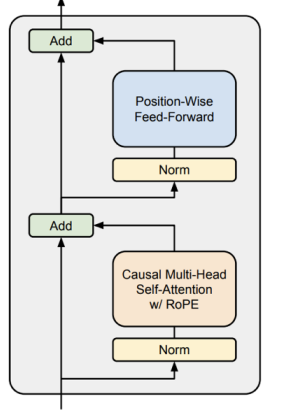

In [ ]:
class TransformerBlock(nnx.Module):
  """A pre-norm Transformer block using RMSNorm and a SwiGLU FFN."""
  def __init__(self, d_model: int, num_heads: int, ff_dim: int, max_seq_len: int, param_dtype: Any, *, rngs: nnx.Rngs):
    # Attention Sub-layer components
    self.attention_norm = RMSNorm(num_features=d_model, rngs=rngs)
    rope_layer = RoPE(theta=10000.0, d_k=d_model // num_heads, max_seq_len=max_seq_len, rngs=rngs)
    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads, rope=rope_layer, use_bias=False, param_dtype=param_dtype, rngs=rngs)

    # Feed-Forward Sub-layer components
    self.ffn_norm = RMSNorm(num_features=d_model, rngs=rngs)
    self.ffn = FeedForwardLayer(d_model=d_model, d_ff=ff_dim, param_dtype=param_dtype, rngs=rngs)

  def __call__(self, x: jax.Array, training: bool = False):
    # Attention block: x + MHA(RMSNorm(x))
    h = x + self.mha(self.attention_norm(x))

    # Feedforward block: h + FFN(RMSNorm(h))
    return h + self.ffn(self.ffn_norm(h))
    return out

## Transformer model

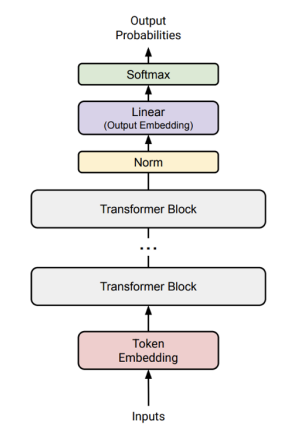

In [ ]:
class MiniLlama(nnx.Module):
  """A data-parallel MiniLLaMA model using RMSNorm and SwiGLU FFN."""

  def __init__(
      self,
      context_length: int,
      vocab_size: int,
      d_model: int,
      num_heads: int,
      feed_forward_dim: int,
      num_layers: int,
      *,
      rngs: nnx.Rngs,
  ):
    param_dtype = jnp.bfloat16

    # Embedding layer
    self.embedding_layer = nnx.Embed(
        num_embeddings=vocab_size,
        features=d_model,
        embedding_init=replicated_normal_init,
        rngs=rngs,
    )

    # Transformer stack
    self.transformer_blocks = [
        TransformerBlock(
            d_model=d_model,
            num_heads=num_heads,
            ff_dim=feed_forward_dim,
            max_seq_len=max_seq_len,
            param_dtype=param_dtype,
            rngs=rngs,
        )
        for _ in range(num_layers)
    ]

    # Final layer norm
    self.output_norm = RMSNorm(num_features=model_d, rngs=rngs)

    # Output projection
    self.output_layer = nnx.Linear(
        in_features=model_d,
        out_features=vocab_size,
        kernel_init=replicated_xavier_init,
        bias_init=replicated_zeros_init,
        rngs=rngs,
    )

    self.max_seq_len = max_seq_len

  def __call__(self, inputs: jax.Array, training: bool = False) -> jax.Array:
    x = self.embedding_layer(inputs) # [b, s] -> [b, s, model_d]
    for block in self.transformer_blocks:
        x = block(x, training=training) # [b, s, model_d]
    x = self.output_norm(x) # [b, s, model_d]
    return self.output_layer(x) # [b, s, vocab_size]

  def generate_text(
      self,
      max_tokens: int,
      start_tokens: List[int],
      top_k: int = 10,
      rng_key = None,
  ) -> List[int]:
    if rng_key is None:
        rng_key = jax.random.PRNGKey(int(time.time()))

    def sample_from(logits: jax.Array, key):
      key, subkey = jax.random.split(key)
      top_logits, top_indices = jax.lax.top_k(logits, k=top_k)
      probs = nnx.softmax(top_logits)
      sampled = jax.random.choice(subkey, top_indices, p=probs)
      return int(sampled.item()), key

    current_tokens = list(start_tokens)
    end_of_text_id = tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'})[0]


    for _ in range(max_tokens):
      context = jnp.array(current_tokens[-self.max_seq_len:])[None, :]  # (1, max_seq_len)
      logits = self(context, training=False)[0, -1, :]                  # (vocab_size,)
      next_token, rng_key = sample_from(logits, rng_key)
      current_tokens.append(next_token)
      if next_token == end_of_text_id:
        break

    return tokenizer.decode(current_tokens)


## Loss function and train step

In [ ]:
# Defines the loss function using `optax.softmax_cross_entropy_with_integer_labels`.
# t1, t2, t3 -> t2, t3, 0
def loss_fn(model, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch[1]).mean()
    return loss, logits

# Define the training step with the `flax.nnx.jit` transformation decorator.
@nnx.jit
def train_step(model: MiniLlama, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    perplexity = jnp.exp(loss)
    metrics.update(loss=loss, perplexity=perplexity, logits=logits, lables=batch[1])
    optimizer.update(grads)

## Training

In [ ]:
model = MiniLlama(max_seq_len, vocab_size, model_d, num_heads, feed_forward_dim, num_layers, rngs=nnx.Rngs(0))

optimizer = nnx.Optimizer(model, optax.adam(1e-3))
metrics = nnx.MultiMetric(
  loss=nnx.metrics.Average('loss'),
  perplexity=nnx.metrics.Average('perplexity')
)
rng = jax.random.PRNGKey(0)

start_prompt = "Once upon a time"
start_tokens = tokenizer.encode(start_prompt)[:max_seq_len]
generated_text = model.generate_text(40, start_tokens)
print(f"Initial generated text:\n{generated_text}\n")

metrics_history = {'train_loss': [], 'train_perplexity': []}

# (s) -> (s)
# (b, s) ->(b, s)
prep_target_batch = jax.vmap(lambda tokens: jnp.concatenate((tokens[1:], jnp.array([0]))))

step = 0
for epoch in range(num_epochs):
  start_time = time.time()
  for batch in text_dl:
    if len(batch) % len(jax.devices()) != 0:
      continue  # skip the remaining elements
    input_batch = jnp.array(batch).T
    target_batch = prep_target_batch(input_batch)

    # print("input_batch: ", input_batch)
    # print("target_batch: ", target_batch)
    train_step(model, optimizer, metrics, jax.device_put((input_batch, target_batch), NamedSharding(mesh, P('batch', None))))

    if (step + 1) % 500 == 0:
      for metric, value in metrics.compute().items():
          metrics_history[f'train_{metric}'].append(value)
      metrics.reset()

      elapsed_time = time.time() - start_time
      print(f"Step {step + 1}, Loss: {metrics_history['train_loss'][-1]:.3f}, Perplexity: {metrics_history['train_perplexity'][-1]:.2f}, Elapsed Time: {elapsed_time:.2f} seconds")
      start_time = time.time()

      generated_text = model.generate_text(40, start_tokens)

      print(f"Generated text:\n{generated_text}\n")
    step += 1

# Final text generation
generated_text = model.generate_text(max_seq_len, start_tokens)
print(f"Final generated text:\n{generated_text}")

Initial generated text:
Once upon a time Farage COMP Forced Hulkukes ac CBIgang existbridge abnormjitJonathanlloSon605 exist Actress quadru SpurductArticle Just classroom Matsagnar fillinginternet chant Easlines linebacklines curtail embedded selects contingencyaxteremed Wilhelm

Step 500, Loss: 3.431, Perplexity: 420.30, Elapsed Time: 145.18 seconds
Generated text:
Once upon a time there was a little bear named Benny who loved to a big party. One day, Benny was playing in the park and he accidentally knocked over the tunnel. Benny's friends ran and hid behind the cave.
After a while, Benny realized that a lot of fun were talking and being selfish. Benny

Step 1000, Loss: 2.142, Perplexity: 8.79, Elapsed Time: 254.99 seconds
Generated text:
Once upon a time, there was a little boy who loved to eat grapes. One day, his mom asked him what day was for dinner, but he didn't eat his grapes. Tim thought that tasted the sweet bananas, but he didn't know how to get any more. His mom was very s